<a href="https://colab.research.google.com/github/pazars/ml-ai-journey/blob/main/energijas_paterins/md_latvenergo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mājsaimniecību ikstundas elektroenerģijas patēriņa prognozēšana

- [Dati](https://sadalestikls.lv/lv/inovacijas/)
- [Pieraksti un piezīmes](https://docs.google.com/document/d/1uRcEQ270ApDZVDmKcD_JqGLWD-sVYUEAu2sNMa_JugE/edit?usp=sharing)
- [Prezentācija](https://docs.google.com/presentation/d/1mesaQgQanmCM91jMtl1BxYz2UFpNacUBq6Jq7b-Kcqs/edit?usp=sharing)

## Vides uzstādīšana

- Datu lejupielāde
- *Weights & Biases* platformas uzstādīšana

In [1]:
%%shell

wget https://sadalestikls.lv/storage/app/media/OpenData_ST.zip

--2023-05-24 10:01:41--  https://sadalestikls.lv/storage/app/media/OpenData_ST.zip
Resolving sadalestikls.lv (sadalestikls.lv)... 83.136.136.75
Connecting to sadalestikls.lv (sadalestikls.lv)|83.136.136.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32547956 (31M) [application/zip]
Saving to: ‘OpenData_ST.zip’

OpenData_ST.zip     100%[===================>]  31.04M  22.2MB/s    in 1.4s    

2023-05-24 10:01:42 (22.2 MB/s) - ‘OpenData_ST.zip’ saved [32547956/32547956]



In [2]:
!ls

OpenData_ST.zip  sample_data


In [3]:
!unzip OpenData_ST.zip

Archive:  OpenData_ST.zip
   creating: OpenData_ST/
  inflating: OpenData_ST/DATA1_1.csv  
  inflating: OpenData_ST/DATA1_2.csv  
  inflating: OpenData_ST/DATA1_3_R.csv  
  inflating: OpenData_ST/DATA1_4.csv  
  inflating: OpenData_ST/DATA1_5.csv  
  inflating: OpenData_ST/DATA1_6_R.csv  
  inflating: OpenData_ST/LIST_EIC_MP_tariff.csv  
  inflating: OpenData_ST/Read-Me.txt  


In [4]:
!ls

OpenData_ST  OpenData_ST.zip  sample_data


In [5]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=065b7cebe7b135c26641847940a1f6bfccbfed5b977ac25c2007e0b5e4ff863a
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


## Datu izpēte

In [6]:
! pip install pandas matplotlib scikit-learn xgboost seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd

pd.__version__

'1.5.3'

In [8]:
import pandas as pd
import glob
import os

all_files = glob.glob(os.path.join("OpenData_ST" , "DATA1_*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep=";")
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)

data.head()

,Date Time,Customer EIC,Object EIC,MP nr,A+,A-,Tariff
0,01.04.2017 01:00,43Z-STO006244838,43Z-STO006244838,2045134,0.4556,0.0,T-1
1,01.04.2017 02:00,43Z-STO006244838,43Z-STO006244838,2045134,0.3268,0.0,T-1
2,01.04.2017 03:00,43Z-STO006244838,43Z-STO006244838,2045134,0.2104,0.0,T-1
3,01.04.2017 04:00,43Z-STO006244838,43Z-STO006244838,2045134,0.5025,0.0,T-1
4,01.04.2017 05:00,43Z-STO006244838,43Z-STO006244838,2045134,0.3265,0.0,T-1


In [9]:
# Convert Date Time column to datetime data type
data["Date Time"] = pd.to_datetime(data["Date Time"], format="%d.%m.%Y %H:%M")

In [10]:
data.shape

(5261400, 7)

In [11]:
data.dtypes

Date Time       datetime64[ns]
Customer EIC            object
Object EIC              object
MP nr                    int64
A+                     float64
A-                     float64
Tariff                  object
dtype: object

In [12]:
data["Tariff"].value_counts()

T-1    4761567
T-3     341991
T-2     157842
Name: Tariff, dtype: int64

In [13]:
# Dataset has no missing values
data.isna().sum()

Date Time       0
Customer EIC    0
Object EIC      0
MP nr           0
A+              0
A-              0
Tariff          0
dtype: int64

In [14]:
data["Date Time"].min()

Timestamp('2017-04-01 01:00:00')

In [15]:
data["Date Time"].max()

Timestamp('2020-04-01 00:00:00')

In [16]:
# There are 199 distinct customers
len(data["Customer EIC"].unique())

199

In [17]:
# And 199 distinct objects
len(data["Object EIC"].unique())

199

In [18]:
# 39 customers are generating electricity
len(data.loc[data["A-"] > 0, "Customer EIC"].unique())

39

In [19]:
# Data is well distributed. All but one customer has 26307 data points. 1 customer has 52614. Dupes?
data.groupby("Customer EIC")["Date Time"].count().value_counts()

26307    198
52614      1
Name: Date Time, dtype: int64

In [20]:
# Customer 43X-STJ000786346 has double the number of values
data["Customer EIC"].value_counts()

43X-STJ000786346    52614
43X-STJ02511421X    26307
43X-STJ00198138Y    26307
43X-STJ00001113Z    26307
43X-STJ02387516H    26307
                    ...  
43X-STP01242823Y    26307
43X-STP01198522X    26307
43X-STP00897087Q    26307
43X-STP010429907    26307
43X-STP00606480Q    26307
Name: Customer EIC, Length: 199, dtype: int64

In [21]:
data.groupby("Customer EIC")["Date Time"].value_counts().sort_values(ascending=False)

Customer EIC      Date Time          
43X-STJ000786346  2018-10-28 04:00:00    4
                  2017-10-29 04:00:00    4
                  2019-10-27 04:00:00    4
                  2019-04-02 15:00:00    2
                  2019-04-02 14:00:00    2
                                        ..
43X-STJ01039179D  2017-04-04 23:00:00    1
                  2017-04-04 22:00:00    1
                  2017-04-04 21:00:00    1
                  2017-04-04 20:00:00    1
43Z-STO006304393  2020-04-01 00:00:00    1
Name: Date Time, Length: 5234496, dtype: int64

In [22]:
# Some duplicate row examples
data.loc[(data["Customer EIC"] == "43X-STJ000786346") & (data["Date Time"] == "28.10.2018 04:00")]

,Date Time,Customer EIC,Object EIC,MP nr,A+,A-,Tariff
1013470,2018-10-28 04:00:00,43X-STJ000786346,43Z-STO00813376S,7474023,4.1256,0.0,T-1
1013471,2018-10-28 04:00:00,43X-STJ000786346,43Z-STO00813376S,7474023,4.1824,0.0,T-1
2986495,2018-10-28 04:00:00,43X-STJ000786346,43Z-STO00813376S,7474023,4.1256,0.0,T-1
2986496,2018-10-28 04:00:00,43X-STJ000786346,43Z-STO00813376S,7474023,4.1824,0.0,T-1


In [23]:
data.loc[(data["Customer EIC"] == "43X-STJ000786346") & (data["Date Time"] == "21.04.2019 11:00")]

,Date Time,Customer EIC,Object EIC,MP nr,A+,A-,Tariff
1017678,2019-04-21 11:00:00,43X-STJ000786346,43Z-STO00813376S,7474023,1.0424,0.0048,T-1
2990703,2019-04-21 11:00:00,43X-STJ000786346,43Z-STO00813376S,7474023,1.0424,0.0000,T-1


In [24]:
data.loc[(data["Customer EIC"] == "43X-STJ00002315C") & (data["Date Time"] == "28.10.2018 04:00")]

,Date Time,Customer EIC,Object EIC,MP nr,A+,A-,Tariff
3933547,2018-10-28 04:00:00,43X-STJ00002315C,43Z-STO01611492L,3736034,363.51,0.0,T-1
3933548,2018-10-28 04:00:00,43X-STJ00002315C,43Z-STO01611492L,3736034,346.50,0.0,T-1


In [25]:
data.loc[data["Customer EIC"] == "43X-STJ000786346"].duplicated()

999666     False
999667     False
999668     False
999669     False
999670     False
           ...  
2998993    False
2998994     True
2998995     True
2998996     True
2998997     True
Length: 52614, dtype: bool

In [26]:
# Duplicate row example (DATA1_2.csv and DATA1_3_R.csv)
# 31.03.2020 21:00;43X-STJ000786346;43Z-STO00813376S;7474023;2.6272;0;T-1
data.iloc[4261730]

Date Time       2020-03-31 21:00:00
Customer EIC       43X-STP00036928B
Object EIC         43Z-STO00621463M
MP nr                       8023104
A+                            0.568
A-                              0.0
Tariff                          T-1
Name: 4261730, dtype: object

In [27]:
data_no_dupes = data.drop_duplicates(subset=["Date Time", "Customer EIC"])

In [28]:
# After dropping duplicates each of the 199 customers has exactly 26304 values
# This means that every customer had at least a few duplicates
data_no_dupes["Customer EIC"].value_counts().value_counts()

26304    199
Name: Customer EIC, dtype: int64

In [29]:
# Number of hours in data range matches number of unique entries for each customer
(data_no_dupes["Date Time"].max() - data_no_dupes["Date Time"].min()).days * 24 + 24

26304

In [30]:
# Based on mean and max values of energy consumption as well as info about the users, energy unit most likely kWh
data_no_dupes.loc[data_no_dupes["A+"] > 0, "A+"].mean()

11.54687972536689

In [31]:
data_no_dupes.loc[data_no_dupes["A+"] > 0, "A+"].max()

977.7

Text(0, 0.5, 'Vērtību skaits')

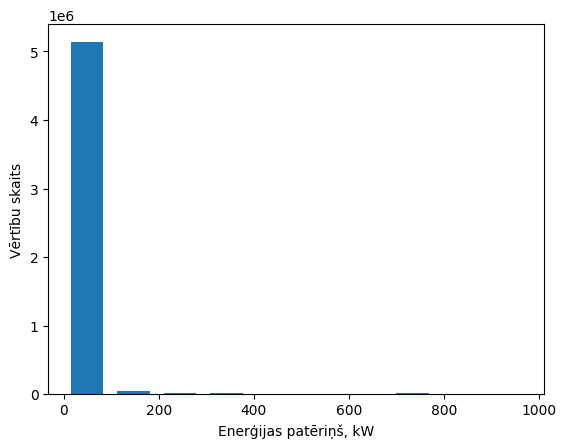

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# data_no_dupes.iloc[:15000]["A+"].plot(kind="hist", ax=ax, rwidth=0.7)
data_no_dupes["A+"].plot(kind="hist", ax=ax, rwidth=0.7)
ax.set_xlabel("Enerģijas patēriņš, kW")
ax.set_ylabel("Vērtību skaits")

## Datu pirmsapstrāde

### Date transformer

In [33]:
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin

In [34]:
"""
The approach here is to:

"""


class CustomDateEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.date_col_name = "Date Time"
        self.new_cols = None

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:

        date_time = X[self.date_col_name]

        months = date_time.dt.month
        year = date_time.dt.year

        month_sin = np.sin((months - 1) * (2.0 * np.pi / 12))
        month_cos = np.cos((months - 1) * (2.0 * np.pi / 12))

        seconds_in_day = 24*60*60
        seconds = (date_time.dt.hour*60*60) + (date_time.dt.minute*60) + (date_time.dt.second)

        X['time_sin'] = np.sin(2*np.pi*seconds/seconds_in_day)
        X['time_cos'] = np.cos(2*np.pi*seconds/seconds_in_day)

        days_in_week = 7

        X['weekday_sin'] = np.sin(2*np.pi*date_time.dt.dayofweek/days_in_week)
        X['weekday_cos'] = np.cos(2*np.pi*date_time.dt.dayofweek/days_in_week)

        X["month_sin"] = month_sin
        X["month_cos"] = month_cos

        X["year"] = year
        X["month"] = months
        X["weekday"] = date_time.dt.dayofweek
        X["monthday"] = date_time.dt.day
        X["hour"] = date_time.dt.hour

        Y = X.drop(labels=self.date_col_name, axis=1)

        self.new_cols = Y.columns

        return Y

    def get_feature_names_out(self, inp: list) -> list:
        return self.new_cols

In [35]:
data.head()

,Date Time,Customer EIC,Object EIC,MP nr,A+,A-,Tariff
0,2017-04-01 01:00:00,43Z-STO006244838,43Z-STO006244838,2045134,0.4556,0.0,T-1
1,2017-04-01 02:00:00,43Z-STO006244838,43Z-STO006244838,2045134,0.3268,0.0,T-1
2,2017-04-01 03:00:00,43Z-STO006244838,43Z-STO006244838,2045134,0.2104,0.0,T-1
3,2017-04-01 04:00:00,43Z-STO006244838,43Z-STO006244838,2045134,0.5025,0.0,T-1
4,2017-04-01 05:00:00,43Z-STO006244838,43Z-STO006244838,2045134,0.3265,0.0,T-1


In [36]:
date_cols = ["Date Time"]
ord_cols = ["Tariff", "MP nr"]
nom_cols = []

In [37]:
from sklearn.pipeline import Pipeline

date_pipe = Pipeline(
    steps=[
        ("datetime_cycle", CustomDateEncoder()),
    ]
)

In [38]:
from sklearn.preprocessing import OrdinalEncoder

ord_pipe = Pipeline(
    steps=[
        ("ord", OrdinalEncoder()),
    ]
)

In [39]:
from sklearn.preprocessing import OneHotEncoder

nom_pipe = Pipeline(
    steps=[
        ("nom", OneHotEncoder(handle_unknown="ignore")),
    ]
)

In [40]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("date", date_pipe, date_cols),
        # ("num", num_pipe, num_cols),
        ("ord", ord_pipe, ord_cols),
        # ("nom", nom_pipe, nom_cols),
    ]
)

In [41]:
# 1095 days in the dataset
# Earliest date is 2017-04-01 01:00:00
# Latest date is 2020-04-01 00:00:00
# 80/20 split is 876/219 or test until 2019-08-25 01:00:00
(data_no_dupes["Date Time"].max() - data_no_dupes["Date Time"].min()).days

1095

In [42]:
train_date_threshold = data_no_dupes["Date Time"].min() + pd.Timedelta(876, unit="d")
valid_date_threshold = train_date_threshold + pd.Timedelta(110, unit="d")

In [43]:
valid_date_threshold

Timestamp('2019-12-13 01:00:00')

In [44]:
train_cols = date_cols + ord_cols + nom_cols + ["A-"]

train_data = data_no_dupes.loc[data_no_dupes["Date Time"] < train_date_threshold, train_cols]
train_labels = data_no_dupes.loc[data_no_dupes["Date Time"] < train_date_threshold, "A+"]

valid_data = data_no_dupes.loc[(data_no_dupes["Date Time"] >= train_date_threshold) & (data_no_dupes["Date Time"] < valid_date_threshold), train_cols]
valid_labels = data_no_dupes.loc[(data_no_dupes["Date Time"] >= train_date_threshold) & (data_no_dupes["Date Time"] < valid_date_threshold), "A+"]

test_data = data_no_dupes.loc[data_no_dupes["Date Time"] >= valid_date_threshold, train_cols]
test_labels = data_no_dupes.loc[data_no_dupes["Date Time"] >= valid_date_threshold, "A+"]

In [45]:
# Transform and save train data
prepro_data = preprocessor.fit_transform(train_data)
new_cols = preprocessor.get_feature_names_out(train_data.columns)
X_train = pd.DataFrame(prepro_data, columns=new_cols)
X_train.to_csv("X_train.csv", index=False)

# Transform and save validation data
prepro_data = preprocessor.fit_transform(valid_data)
new_cols = preprocessor.get_feature_names_out(valid_data.columns)
X_valid = pd.DataFrame(prepro_data, columns=new_cols)
X_valid.to_csv("X_valid.csv", index=False)

# Transform and save test data
prepro_data = preprocessor.fit_transform(test_data)
new_cols = preprocessor.get_feature_names_out(test_data.columns)
X_test = pd.DataFrame(prepro_data, columns=new_cols)
X_test.to_csv("X_test.csv", index=False)

In [46]:
data_no_dupes.head()

,Date Time,Customer EIC,Object EIC,MP nr,A+,A-,Tariff
0,2017-04-01 01:00:00,43Z-STO006244838,43Z-STO006244838,2045134,0.4556,0.0,T-1
1,2017-04-01 02:00:00,43Z-STO006244838,43Z-STO006244838,2045134,0.3268,0.0,T-1
2,2017-04-01 03:00:00,43Z-STO006244838,43Z-STO006244838,2045134,0.2104,0.0,T-1
3,2017-04-01 04:00:00,43Z-STO006244838,43Z-STO006244838,2045134,0.5025,0.0,T-1
4,2017-04-01 05:00:00,43Z-STO006244838,43Z-STO006244838,2045134,0.3265,0.0,T-1


In [47]:
X_train.head()

,date__time_sin,date__time_cos,date__weekday_sin,date__weekday_cos,date__month_sin,date__month_cos,date__year,date__month,date__weekday,date__monthday,date__hour,ord__Tariff,ord__MP nr
0,0.258819,0.965926,-0.974928,-0.222521,1.0,6.123234e-17,2017.0,4.0,5.0,1.0,1.0,0.0,37.0
1,0.500000,0.866025,-0.974928,-0.222521,1.0,6.123234e-17,2017.0,4.0,5.0,1.0,2.0,0.0,37.0
2,0.707107,0.707107,-0.974928,-0.222521,1.0,6.123234e-17,2017.0,4.0,5.0,1.0,3.0,0.0,37.0
3,0.866025,0.500000,-0.974928,-0.222521,1.0,6.123234e-17,2017.0,4.0,5.0,1.0,4.0,0.0,37.0
4,0.965926,0.258819,-0.974928,-0.222521,1.0,6.123234e-17,2017.0,4.0,5.0,1.0,5.0,0.0,37.0


In [48]:
train_labels.to_csv("y_train.csv", index=False)
valid_labels.to_csv("y_valid.csv", index=False)
test_labels.to_csv("y_test.csv", index=False)

In [49]:
X_train.shape, X_valid.shape, X_test.shape

((4183776, 13), (525360, 13), (525360, 13))

In [50]:
train_labels.shape, valid_labels.shape, test_labels.shape

((4183776,), (525360,), (525360,))

## Modeļa izveide

- wand.ai eksperimentēšanai
- [Neural net dizains](https://towardsdatascience.com/designing-your-neural-networks-a5e4617027ed)

In [52]:
!ls

OpenData_ST	 sample_data  X_train.csv  y_test.csv	y_valid.csv
OpenData_ST.zip  X_test.csv   X_valid.csv  y_train.csv


In [53]:
# normalized_df=(df-df.mean())/df.std()

In [52]:
# If pre-processing has been performed before, the processed data and labels should be saved as X.csv and y.csv
# Can run code from here

import pandas as pd

x_train = pd.read_csv("X_train.csv")
x_valid = pd.read_csv("X_valid.csv")
x_test = pd.read_csv("X_test.csv")

y_train = pd.read_csv("y_train.csv").squeeze(axis=1)
y_valid = pd.read_csv("y_valid.csv").squeeze(axis=1)
y_test = pd.read_csv("y_test.csv").squeeze(axis=1)

### Basic Decision Tree using scikit-learn

- Robust, simple and fast
- Handles raw data well

In [56]:
from sklearn.metrics import mean_absolute_error, max_error

def fit_and_eval_model(model, x_train, y_train, x_valid, x_test):
  model.fit(x_train, y_train)

  y_train_pred = model.predict(x_train)
  y_valid_pred = model.predict(x_valid)
  y_test_pred = model.predict(x_test)

  print("Training set:", mean_absolute_error(y_train, y_train_pred), max_error(y_train, y_train_pred))
  print("Validation set:", mean_absolute_error(y_valid, y_valid_pred), max_error(y_valid, y_valid_pred))
  print("Test set:", mean_absolute_error(y_test, y_test_pred), max_error(y_test, y_test_pred))

In [150]:
from sklearn.tree import DecisionTreeRegressor

In [163]:
# Default settings
tree = DecisionTreeRegressor(random_state=0)
fit_and_eval_model(tree, x_train, y_train, x_valid, x_test)

Training set: 4.7979655007311626e-20 1.4210854715202004e-14
Validation set: 4.3212140562661805 806.16
Test set: 4.079983423176489 756.3000000000001


In [158]:
# Settings experiment #1
tree = DecisionTreeRegressor(random_state=0, min_samples_split=3)
fit_and_eval_model(tree, x_train, y_train, x_valid, x_test)

Training set: 0.23684943017981838 245.53500000000003
Validation set: 4.377493730394398 806.16
Test set: 4.051172996326328 756.075


In [159]:
# Settings experiment #2
tree = DecisionTreeRegressor(random_state=0, min_samples_split=5)
fit_and_eval_model(tree, x_train, y_train, x_valid, x_test)

Training set: 0.4776082952871598 357.16499999999996
Validation set: 4.280729837333764 805.95
Test set: 4.049451542259911 798.4350000000001


In [160]:
# Settings experiment #3
tree = DecisionTreeRegressor(random_state=0, max_depth=25)
fit_and_eval_model(tree, x_train, y_train, x_valid, x_test)

Training set: 0.3183713122972746 115.92000000000007
Validation set: 4.312030250127854 806.16
Test set: 4.060533189451875 790.4399999999999


In [162]:
# Settings experiment #4
tree = DecisionTreeRegressor(random_state=0, max_features="auto")
fit_and_eval_model(tree, x_train, y_train, x_valid, x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


Training set: 4.7979655007311626e-20 1.4210854715202004e-14
Validation set: 4.3212140562661805 806.16
Test set: 4.079983423176489 756.3000000000001


### Random Forest Regressor using scikit-learn

In [58]:
from sklearn.ensemble import RandomForestRegressor

In [6]:
forest = RandomForestRegressor(random_state=0, n_estimators=5)
fit_and_eval_model(forest, x_train, y_train, x_valid, x_test)

Training set: 0.4523258251292608 481.17600000000004
Validation set: 3.9852666176336218 771.9
Test set: 3.9218251556266184 752.328


In [59]:
forest = RandomForestRegressor(random_state=0, n_estimators=10)
fit_and_eval_model(forest, x_train, y_train, x_valid, x_test)

Training set: 0.42066583681726805 313.077
Validation set: 4.032123940459875 673.386
Test set: 3.849664858649308 734.2170000000001


### XGBoost Regressor using XGBoost with scikit-learn API

In [61]:
from xgboost import XGBRegressor

xgbr = XGBRegressor(random_state=0, n_estimators=5)
fit_and_eval_model(xgbr, x_train, y_train, x_valid, x_test)

Training set: 6.607303189268461 544.0270385742188
Validation set: 6.714192442294433 404.565146484375
Test set: 7.256715799538317 465.3599853515625


In [62]:
xgbr = XGBRegressor(random_state=0, n_estimators=20)
fit_and_eval_model(xgbr, x_train, y_train, x_valid, x_test)

Training set: 4.711831833482562 645.111328125
Validation set: 4.823864305292607 532.0739990234375
Test set: 5.637237739174078 584.7471752929688


In [63]:
xgbr = XGBRegressor(random_state=0, n_estimators=100)
fit_and_eval_model(xgbr, x_train, y_train, x_valid, x_test)

Training set: 3.1760692547060567 673.2929077148438
Validation set: 3.7886831738478333 603.8301733398438
Test set: 4.290332409368711 612.2581176757812


In [91]:
y_test.mean(), y_test.median()

(12.39794169255368, 1.2311)

### Statistical estimations

In [87]:
import numpy as np

# 0 guess error

y_0 = np.zeros(shape=(y_test.size,))
y_mean = np.ones(shape=(y_test.size,)) * y_test.mean()
y_med = np.ones(shape=(y_test.size,)) * y_test.median()

mean_absolute_error(y_test, y_0), mean_absolute_error(y_test, y_mean), mean_absolute_error(y_test, y_med)

(12.39794169255368, 17.69566003734559, 11.936440752626769)

In [88]:
from sklearn.metrics import max_error

max_error(y_test, y_0), max_error(y_test, y_mean), max_error(y_test, y_med)

(918.51, 906.1120583074463, 917.2789)

In [89]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_0), mean_squared_error(y_test, y_mean), mean_squared_error(y_test, y_med)

(3954.492790551285, 3800.783832339325, 3925.482185725881)

### Deep Neural Network using Tensorflow

In [51]:
import wandb

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [97]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [53]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [54]:
# Hyperparameters

BATCH_SIZE = 64

In [55]:
# Prepare the training dataset

# build input pipeline using tf.data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(BATCH_SIZE)

In [98]:
def make_model():
    nparams = x_train.shape[1]

    model = keras.Sequential()
    model.add(keras.Input(shape=(nparams,)))
    model.add(layers.Dense(199, activation="linear"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))

    return model


In [99]:
model = make_model()

In [100]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 256)               3584      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 64)                16448     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 1)                 65        
                                                                 
Total params: 20,097
Trainable params: 20,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.fit(train_dataset, batch_size=BATCH_SIZE, epochs=3, validation_data=val_dataset, callbacks=[tf.keras.callbacks.EarlyStopping()])

Epoch 1/3
65372/65372 [==============================] - 307s 5ms/step - loss: 740.9367 - mean_absolute_error: 5.4903 - val_loss: 3947.0867 - val_mean_absolute_error: 12.4234
Epoch 2/3
65372/65372 [==============================] - 291s 4ms/step - loss: 765.1546 - mean_absolute_error: 5.5132 - val_loss: 3940.6846 - val_mean_absolute_error: 12.0599
Epoch 3/3
19382/65372 [=======>......................] - ETA: 3:05 - loss: 1288.8383 - mean_absolute_error: 6.0374

In [95]:
# Evaluate model's performance on the test set
model.evaluate(x_test, y_test)

16418/16418 [==============================] - 41s 2ms/step - loss: 3936.6765 - mean_absolute_error: 11.9825


[3936.676513671875, 11.982545852661133]

In [ ]:
# Manually calculate max error
y_test_pred = model.predict(x_test)

np.max(np.abs(y_test_pred - y_test))

In [57]:
def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y, logits)

    return loss_value

In [58]:
def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

In [59]:
def train(train_dataset, val_dataset,  model, optimizer,
          train_acc_metric, val_acc_metric,
          epochs=1):
  
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []   
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train, 
                                    model, optimizer, 
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

            if step % 5000 == 0:
              print(f"Step: {step}/{len(train_dataset)}")

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val, 
                                       model, loss_fn, 
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))
            
        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        # ⭐: log metrics using wandb.log
        wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc), 
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})

In [60]:
# initialize wandb with your project name and optionally with configutations.
# play around with the config values and see the result on your wandb dashboard.
config = {
              "learning_rate": 0.05,
              "epochs": 2,
              "batch_size": BATCH_SIZE,
              "architecture": "Full connected neural network",
              "dataset": "https://sadalestikls.lv/storage/app/media/OpenData_ST.zip"
           }

run = wandb.init(project='latvenergo-md', config=config)
config = wandb.config

# Initialize model.
model = make_model()

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate)
# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError()

# Prepare the metrics.
train_acc_metric = tf.keras.metrics.RootMeanSquaredError()
val_acc_metric = tf.keras.metrics.RootMeanSquaredError()

train(train_dataset,
      val_dataset, 
      model,
      optimizer,
      train_acc_metric,
      val_acc_metric,
      epochs=config.epochs)

run.finish()  # In Jupyter/Colab, let us know you're finished!

wandb: Currently logged in as: davis-pazars. Use `wandb login --relogin` to force relogin



Start of epoch 0


Step: 0/65372
Step: 5000/65372
Step: 10000/65372


KeyboardInterrupt: ignored

## Rezultātu pēcapstrāde

In [ ]:
x_test

,date__time_sin,date__time_cos,date__weekday_sin,date__weekday_cos,date__month_sin,date__month_cos,date__year,date__month,date__weekday,date__monthday,date__hour,ord__Tariff,ord__MP nr
0,0.258819,0.965926,-0.433884,-0.900969,-0.500000,8.660254e-01,2019.0,12.0,4.0,13.0,1.0,0.0,62.0
1,0.500000,0.866025,-0.433884,-0.900969,-0.500000,8.660254e-01,2019.0,12.0,4.0,13.0,2.0,0.0,62.0
2,0.707107,0.707107,-0.433884,-0.900969,-0.500000,8.660254e-01,2019.0,12.0,4.0,13.0,3.0,0.0,62.0
3,0.866025,0.500000,-0.433884,-0.900969,-0.500000,8.660254e-01,2019.0,12.0,4.0,13.0,4.0,0.0,62.0
4,0.965926,0.258819,-0.433884,-0.900969,-0.500000,8.660254e-01,2019.0,12.0,4.0,13.0,5.0,0.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525355,-0.866025,0.500000,0.781831,0.623490,0.866025,5.000000e-01,2020.0,3.0,1.0,31.0,20.0,0.0,91.0
525356,-0.707107,0.707107,0.781831,0.623490,0.866025,5.000000e-01,2020.0,3.0,1.0,31.0,21.0,0.0,91.0
525357,-0.500000,0.866025,0.781831,0.623490,0.866025,5.000000e-01,2020.0,3.0,1.0,31.0,22.0,0.0,91.0
525358,-0.258819,0.965926,0.781831,0.623490,0.866025,5.000000e-01,2020.0,3.0,1.0,31.0,23.0,0.0,91.0


In [ ]:
y_pred = model.predict(x_test)

16418/16418 [==============================] - 39s 2ms/step


In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError(reduction=tf.keras.losses.Reduction.NONE)
test_mape = mape(y_test, y_pred.squeeze(axis=1)).numpy()

In [ ]:
test_mape

1534869.0

In [ ]:
y_test

0         2.2132
1         2.1993
2         2.2162
3         2.1032
4         2.0558
           ...  
525355    0.7502
525356    0.3955
525357    0.4125
525358    0.3933
525359    0.4035
Name: A+, Length: 525360, dtype: float64

In [ ]:
y_pred.squeeze(axis=1)

array([0.34603408, 0.34603408, 0.34603408, ..., 0.34603408, 0.34603408,
       0.34603408], dtype=float32)